# **AML_CONVOLUTION_ASSIGNMENT**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divya0369","key":"d876fe8d72f07dba952c7ccc28fab3f8"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

100% 812M/812M [00:38<00:00, 21.4MB/s]
100% 812M/812M [00:38<00:00, 21.9MB/s]


Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test
sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network
that you train from scratch. What performance did you achieve?


In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=667, end_index=1667)
make_subset("validation", start_index=1668, end_index=2168)
make_subset("test", start_index=2169, end_index=2669)


Data preprocessing

In [5]:
# Managing the file direcotry; Splitting the file system into train(1000), test(500) and validation(500) folders
from tensorflow.keras.utils import image_dataset_from_directory

training_datasets = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
valid_datasets = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
testing_datasets = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Make a NumPy array of 1000 random samples, each with a vector size of 16, then create a dataset instance.

In [6]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)


Batching the data into 32-size batches

In [7]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break


(16,)
(16,)
(16,)


In [8]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break


(32, 16)
(32, 16)
(32, 16)


In [9]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Show the labels and data shapes according to the dataset.

In [10]:
for data_batch, labels_batch in training_datasets:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Build the model

Including a little convolutional neural network for classifying dogs and cats

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
a = layers.Rescaling(1./255)(inputs)
a = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.Flatten()(a)
a = layers.Dropout(0.5)(a)
outputs = layers.Dense(1, activation="sigmoid")(a)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Overview of the model

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=30,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.4944 - loss: 0.7030 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.5149 - loss: 0.6924 - val_accuracy: 0.5110 - val_loss: 0.6912
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5103 - loss: 0.6994 - val_accuracy: 0.5210 - val_loss: 0.6881
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5424 - loss: 0.6885 - val_accuracy: 0.5970 - val_loss: 0.6707
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5691 - loss: 0.6722 - val_accuracy: 0.5950 - val_loss: 0.6661
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.6000 - loss: 0.6794 - val_accuracy: 0.5960 - val_loss: 0.6634
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6020 - loss: 0.6515 - val_accuracy: 0.5920 - val_loss: 0.7169
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6552 - loss: 0.6427 - val_accuracy: 0.6520 -

Show the loss and accuracy curves when training



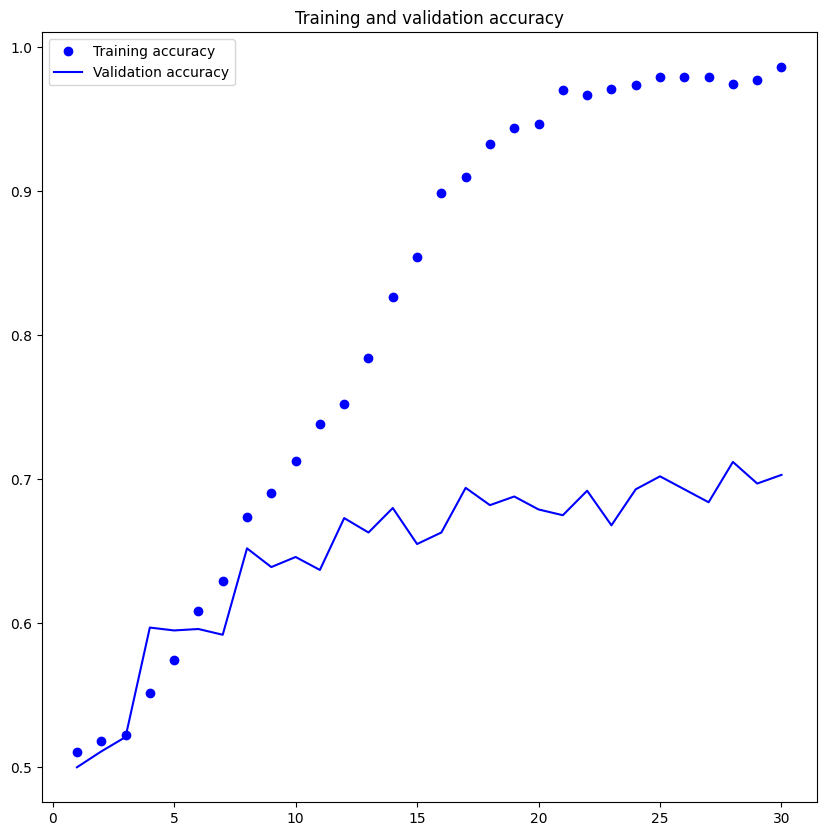

<Figure size 640x480 with 0 Axes>

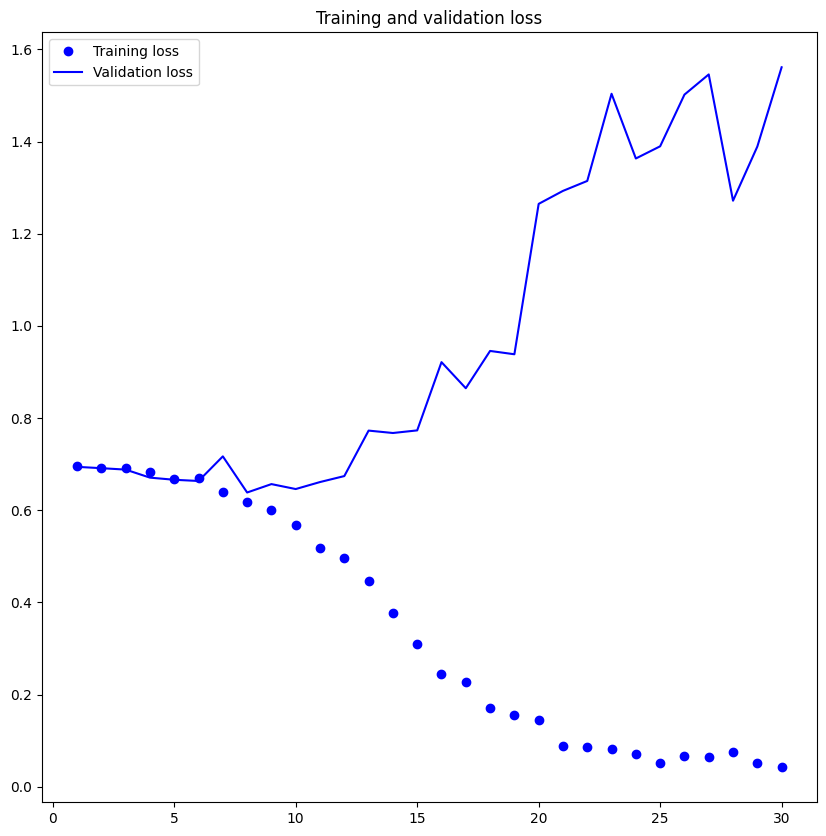

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6814 - loss: 0.6138
Test accuracy: 0.668


Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

In [17]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2167)
make_subset("validation", start_index=2168, end_index=2668)
make_subset("test", start_index=2669, end_index=3168)

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Show a few randomly selected enhanced training photos.

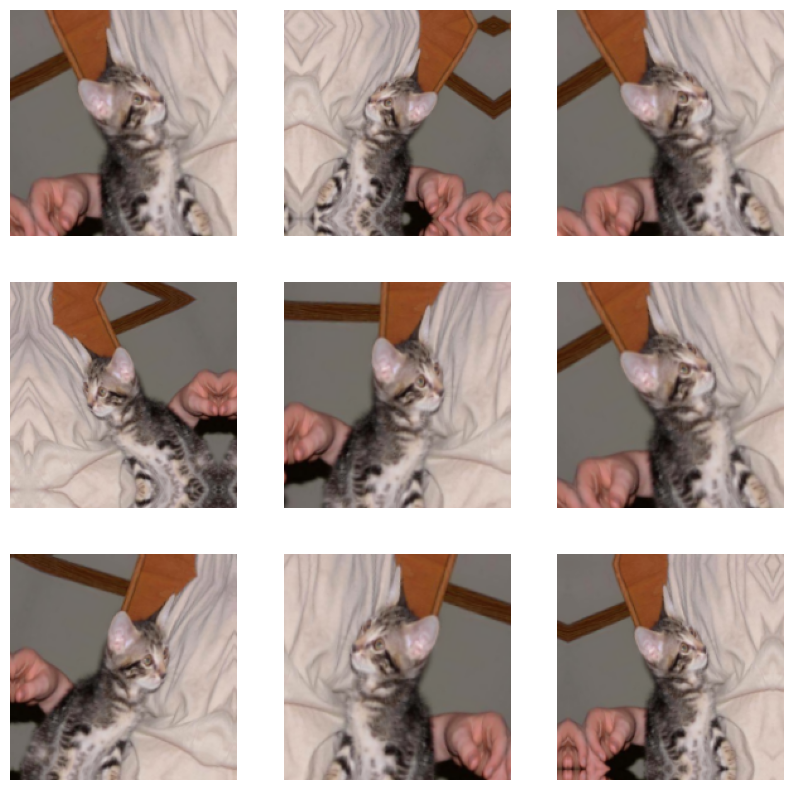

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in training_datasets.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Establishing a new convolutional neural network with dropout and image enhancement features

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=50,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 4s 21ms/step - loss: 0.6947 - accuracy: 0.5030 - val_loss: 0.6909 - val_accuracy: 0.5880
Epoch 2/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6858 - accuracy: 0.5535 - val_loss: 0.6674 - val_accuracy: 0.6060
Epoch 3/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6721 - accuracy: 0.5915 - val_loss: 0.6612 - val_accuracy: 0.6230
Epoch 4/50
63/63 [==============================] - 1s 17ms/step - loss: 0.6447 - accuracy: 0.6330 - val_loss: 0.6907 - val_accuracy: 0.5980
Epoch 5/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6409 - accuracy: 0.6445 - val_loss: 0.6404 - val_accuracy: 0.6550
Epoch 6/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6339 - accuracy: 0.6305 - val_loss: 0.6402 - val_accuracy: 0.6400
Epoch 7/50
63/63 [==============================] - 1s 16ms/step - loss: 0.6297 - accuracy: 0.6505 - val_loss: 0.6443 - val_accuracy: 0.6430
Epoch 8/50
63

Utilizing the test set to assess the model

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 7ms/step - loss: 0.4169 - accuracy: 0.8170
Test accuracy: 0.817


Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.


Keeping the validation and test sets the same (500 samples), while increasing the training sample to 2000

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2667)
make_subset("validation", start_index=2668, end_index=3168)
make_subset("test", start_index=3169, end_index=3669)

Defining a new convolutional neural network with image augmentation, dropout, and more training samples

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=50,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 4s 21ms/step - loss: 0.6961 - accuracy: 0.5055 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6928 - accuracy: 0.5195 - val_loss: 0.6894 - val_accuracy: 0.5080
Epoch 3/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6911 - accuracy: 0.5140 - val_loss: 0.6865 - val_accuracy: 0.5380
Epoch 4/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6882 - accuracy: 0.5445 - val_loss: 0.6822 - val_accuracy: 0.5560
Epoch 5/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6858 - accuracy: 0.5370 - val_loss: 0.6789 - val_accuracy: 0.5790
Epoch 6/50
63/63 [==============================] - 1s 17ms/step - loss: 0.6898 - accuracy: 0.5285 - val_loss: 0.6789 - val_accuracy: 0.6250
Epoch 7/50
63/63 [==============================] - 1s 19ms/step - loss: 0.6742 - accuracy: 0.5705 - val_loss: 0.6636 - val_accuracy: 0.6120
Epoch 8/50
63

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 7ms/step - loss: 0.4733 - accuracy: 0.8010
Test accuracy: 0.801


Using 1,000 instances, a basic convolutional neural network (convnet) was trained in the first phase, achieving a classification accuracy of roughly 70%. It was determined that overfitting was the primary reason for worry. Then optimization methods like dropout, regularization, early halting, and data augmentation were applied to enhance the model. The accuracy of the model increased significantly to 80% once data augmentation was applied.

This improvement was followed by a focus on finding the optimum training samples to further increase classification accuracy. A number of tactics were examined to counteract overfitting, including altering the training set and utilizing additional optimization techniques. These included increasing the training sample size, lowering the network's capacity, incorporating dropout, and adding weight regularization. These methods were successful in lowering overfitting and improving the model's ability to generalize.

Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Pre-trained model-based feature extraction

Convolutional base VGG16 instantiation

In [ ]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Prestrained model-based feature extraction without data augmentation

Taking out the VGG16 characteristics and their labels

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(training_datasets)
val_features, val_labels =  get_features_and_labels(valid_datasets)
test_features, test_labels =  get_features_and_labels(testing_datasets)

1/1 [==============================] - 0s 21ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

Define and train the classifier with dense connections.

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 11.6859 - accuracy: 0.9270 - val_loss: 3.9916 - val_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 3.6200 - accuracy: 0.9745 - val_loss: 8.7446 - val_accuracy: 0.9600
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.5690 - accuracy: 0.9895 - val_loss: 2.7876 - val_accuracy: 0.9780
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 1.2622 - accuracy: 0.9915 - val_loss: 4.1953 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 0.7950 - accuracy: 0.9895 - val_loss: 4.0060 - val_accuracy: 0.9770
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.5633 - accuracy: 0.9950 - val_loss: 4.1504 - val_accuracy: 0.9810
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.7477 - accuracy: 0.9940 - val_loss: 4.4786 - val_accuracy: 0.9790
Epoch 8/20
63/63 [=

Calculate the results and plot them.

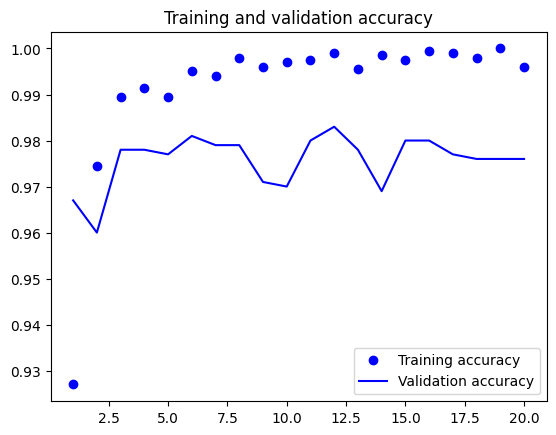

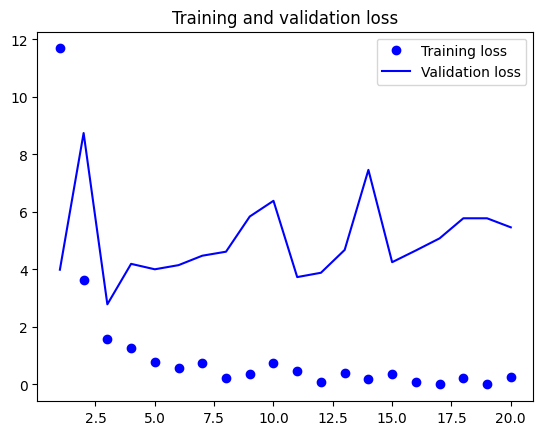

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Using a pretrained model to extract features while augmenting data

Setting up the VGG16 convolutional base and freezing it

In [ ]:
convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_base.trainable = False

In [ ]:
convolution_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
convolution_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


To the convolutional base, adding a classifier and a data augmentation stage

In [ ]:
augmentation2 = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = convolution_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=50,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 4s 38ms/step - loss: 27.3247 - accuracy: 0.8835 - val_loss: 12.5715 - val_accuracy: 0.9330
Epoch 2/50
63/63 [==============================] - 2s 28ms/step - loss: 7.2298 - accuracy: 0.9505 - val_loss: 19.3305 - val_accuracy: 0.9120
Epoch 3/50
63/63 [==============================] - 2s 35ms/step - loss: 6.5287 - accuracy: 0.9550 - val_loss: 4.5673 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 2s 34ms/step - loss: 4.8890 - accuracy: 0.9630 - val_loss: 4.5106 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 2s 35ms/step - loss: 3.7784 - accuracy: 0.9655 - val_loss: 2.2957 - val_accuracy: 0.9820
Epoch 6/50
63/63 [==============================] - 2s 28ms/step - loss: 4.3997 - accuracy: 0.9655 - val_loss: 2.8734 - val_accuracy: 0.9820
Epoch 7/50
63/63 [==============================] - 2s 27ms/step - loss: 3.3774 - accuracy: 0.9695 - val_loss: 4.8522 - val_accuracy: 0.9670
Epoch 8/50

Using the test set to assess the model

In [ ]:
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras",safe_mode=False)
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 3.5184 - accuracy: 0.9750
Test accuracy: 0.975


A fine-tuning VGG16 model that has been pretrained


To fine-tune a frozen model foundation used for feature extraction, a few top layers must be unfrozen. Then, the newly added component of the model (in this case, the fully connected classifier) and these top layers must be trained simultaneously. This process is known as fine-tuning because it makes the more abstract model representations that are being employed more pertinent to the current job.

In [ ]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

Enhancing the model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=30,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 5s 43ms/step - loss: 0.4846 - accuracy: 0.9885 - val_loss: 1.5362 - val_accuracy: 0.9820
Epoch 2/30
63/63 [==============================] - 2s 35ms/step - loss: 0.4957 - accuracy: 0.9885 - val_loss: 1.4219 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 2s 26ms/step - loss: 0.2054 - accuracy: 0.9935 - val_loss: 1.5086 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 2s 35ms/step - loss: 0.3153 - accuracy: 0.9900 - val_loss: 1.3695 - val_accuracy: 0.9840
Epoch 5/30
63/63 [==============================] - 2s 27ms/step - loss: 0.2380 - accuracy: 0.9915 - val_loss: 2.0523 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 2s 27ms/step - loss: 0.2246 - accuracy: 0.9930 - val_loss: 1.3737 - val_accuracy: 0.9840
Epoch 7/30
63/63 [==============================] - 2s 34ms/step - loss: 0.3267 - accuracy: 0.9940 - val_loss: 1.3592 - val_accuracy: 0.9880
Epoch 8/30
63

In [ ]:
model = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 2.2150 - accuracy: 0.9730
Test accuracy: 0.973
